In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load data
conn = sqlite3.connect("../fraud.db")
df = pd.read_sql("SELECT * FROM transactions", conn)
conn.close()

In [5]:
# Convert date
df["transactionDateTime"] = pd.to_datetime(df["transactionDateTime"])
df["hour"] = df["transactionDateTime"].dt.hour
df["dayofweek"] = df["transactionDateTime"].dt.day_name()

In [6]:
# Move 'isFraud' column to the end
is_fraud = df.pop('isFraud')
df['isFraud'] = is_fraud

In [7]:

df.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,merchantName,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,hour,dayofweek,isFraud
0,737265056,5000,5000.0,2016-08-13 14:27:32,Uber,98.55,US,US,2.0,1.0,...,414,414,1803,PURCHASE,0.0,0,0,14,Saturday,0
1,737265056,5000,5000.0,2016-10-11 05:05:54,AMC #191138,74.51,US,US,9.0,1.0,...,486,486,767,PURCHASE,0.0,1,0,5,Tuesday,0
2,737265056,5000,5000.0,2016-11-08 09:18:39,Play Store,7.47,US,US,9.0,1.0,...,486,486,767,PURCHASE,0.0,0,0,9,Tuesday,0
3,737265056,5000,5000.0,2016-12-10 02:14:50,Play Store,7.47,US,US,9.0,1.0,...,486,486,767,PURCHASE,0.0,0,0,2,Saturday,0
4,830329091,5000,5000.0,2016-03-24 21:04:46,Tim Hortons #947751,71.18,US,US,2.0,1.0,...,885,885,3143,PURCHASE,0.0,1,0,21,Thursday,0


In [8]:
# Basic structure
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Dtypes:\n", df.dtypes)
print("Missing values:\n", df.isna().sum())

Shape: (786363, 24)
Columns: ['accountNumber', 'creditLimit', 'availableMoney', 'transactionDateTime', 'merchantName', 'transactionAmount', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'hour', 'dayofweek', 'isFraud']
Dtypes:
 accountNumber                        int64
creditLimit                          int64
availableMoney                     float64
transactionDateTime         datetime64[ns]
merchantName                        object
transactionAmount                  float64
acqCountry                          object
merchantCountryCode                 object
posEntryMode                       float64
posConditionCode                   float64
merchantCategoryCode                object
currentExpDate                      object
accountOpenDate   

In [9]:
# Fraud label
print("Fraud count:\n", df["isFraud"].value_counts())
fraud_rate = df["isFraud"].mean()
print(f"Fraud rate: {fraud_rate:.4%}")

Fraud count:
 isFraud
0    773946
1     12417
Name: count, dtype: int64
Fraud rate: 1.5790%


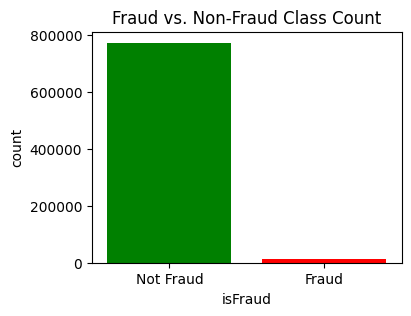

In [10]:
# Plot fraud distribution
plt.figure(figsize=(4,3))
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs. Non-Fraud Class Count")
plt.xticks([0, 1], ["Not Fraud", "Fraud"])
ax = plt.gca()
for patch, color in zip(ax.patches, ['green', 'red']):
    patch.set_facecolor(color)
plt.show()

In [11]:
# Time range
print("Transaction time range:\n", df["transactionDateTime"].describe())

Transaction time range:
 count                           786363
mean     2016-07-06 01:58:58.395681536
min                2016-01-01 00:01:02
25%                2016-04-06 19:35:07
50%                2016-07-08 05:03:57
75%         2016-10-05 13:52:03.500000
max                2016-12-30 23:59:45
Name: transactionDateTime, dtype: object


Fraud time range:
 count                            12417
mean     2016-06-30 04:18:50.739872768
min                2016-01-01 00:04:10
25%                2016-03-30 11:31:38
50%                2016-06-29 06:15:10
75%                2016-09-28 22:42:59
max                2016-12-30 23:15:04
Name: transactionDateTime, dtype: object


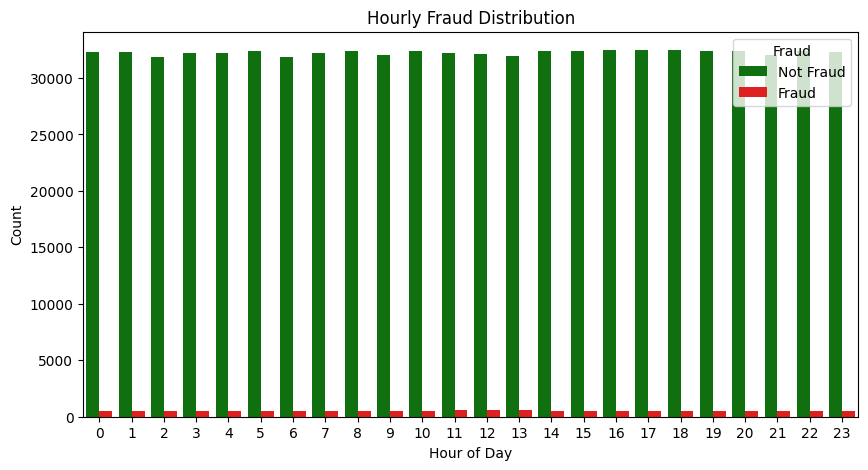

In [12]:
print("Fraud time range:\n", df[df["isFraud"] == 1]["transactionDateTime"].describe())
# Hourly fraud distribution
plt.figure(figsize=(10, 5))
sns.countplot(x="hour", hue="isFraud", data=df, palette=["green", "red"])
plt.title("Hourly Fraud Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.legend(title="Fraud", loc='upper right', labels=["Not Fraud", "Fraud"])
plt.show()

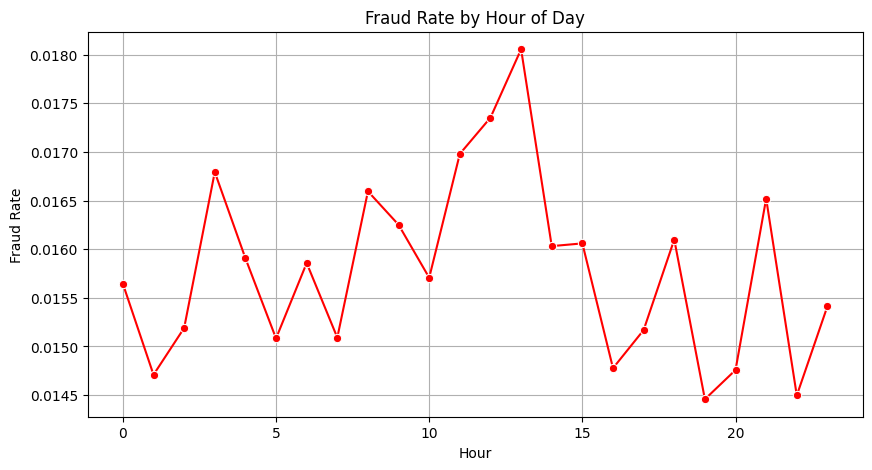

In [13]:
# Fraud rate per hour
hour_summary = df.groupby("hour").agg(
    total_txns=("isFraud", "count"),
    fraud_count=("isFraud", "sum")
)
hour_summary["fraud_rate"] = hour_summary["fraud_count"] / hour_summary["total_txns"]

plt.figure(figsize=(10,5))
sns.lineplot(data=hour_summary, x=hour_summary.index, y="fraud_rate", marker="o", color="red")
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Rate")
plt.xlabel("Hour")
plt.grid(True)
plt.show()


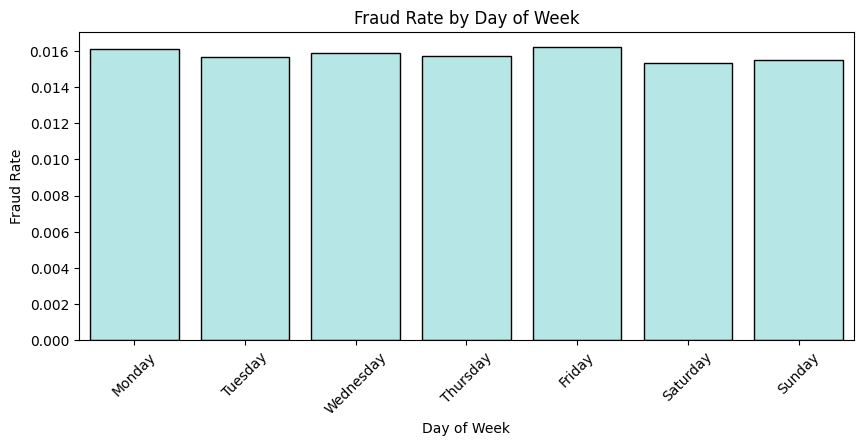

In [14]:
# Ensure dayofweek is ordered correctly
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["dayofweek"] = pd.Categorical(df["dayofweek"], categories=day_order, ordered=True)

dow_summary = df.groupby("dayofweek", observed=False).agg(
    total_txns=("isFraud", "count"),
    fraud_count=("isFraud", "sum")
)
dow_summary["fraud_rate"] = dow_summary["fraud_count"] / dow_summary["total_txns"]

plt.figure(figsize=(10,4))
sns.barplot(
    data=dow_summary.reset_index(), 
    x="dayofweek", 
    y="fraud_rate", 
    color="paleturquoise",
    edgecolor="black",
)
plt.title("Fraud Rate by Day of Week")
plt.ylabel("Fraud Rate")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.show()



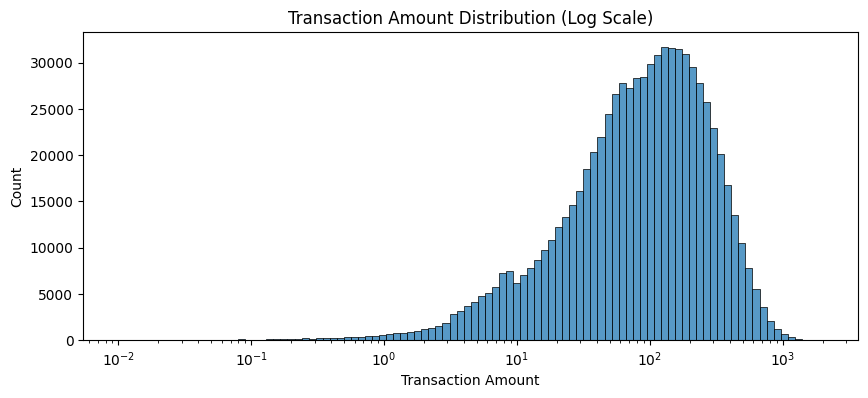

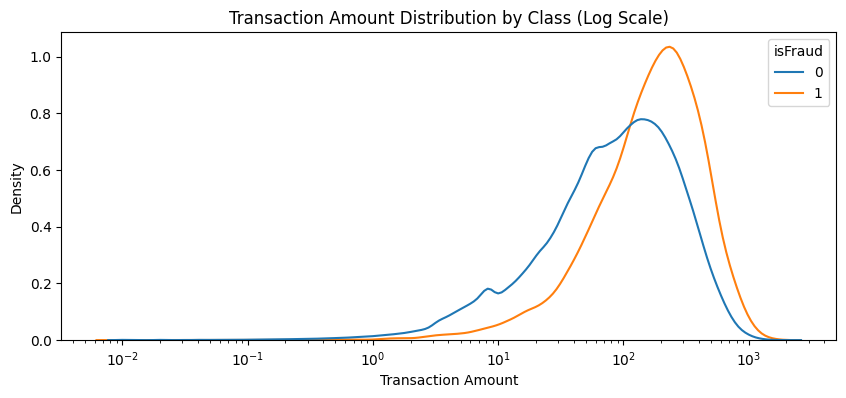

In [15]:
# Log-scale histogram of all transaction amounts
plt.figure(figsize=(10,4))
sns.histplot(df["transactionAmount"], bins=100, log_scale=(True, False), kde=False)
plt.title("Transaction Amount Distribution (Log Scale)")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.show()

# Compare fraud vs non-fraud amount distributions
# Filter out rows with null or zero amounts
clean_df = df[df["transactionAmount"] > 0].copy()

plt.figure(figsize=(10,4))
sns.kdeplot(
    data=clean_df,
    x="transactionAmount",
    hue="isFraud",
    log_scale=True,
    common_norm=False
)
plt.title("Transaction Amount Distribution by Class (Log Scale)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()




In [16]:
plt.figure(figsize=(10,4))
sns.barplot(
    x=cat_summary.index,
    y=cat_summary["fraud_rate"],
    palette=sns.color_palette("Reds_r", n_colors=len(cat_summary))
)
plt.title("Top Merchant Categories by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.xlabel("Merchant Category Code")
plt.xticks(rotation=45)
plt.show()


NameError: name 'cat_summary' is not defined

<Figure size 1000x400 with 0 Axes>

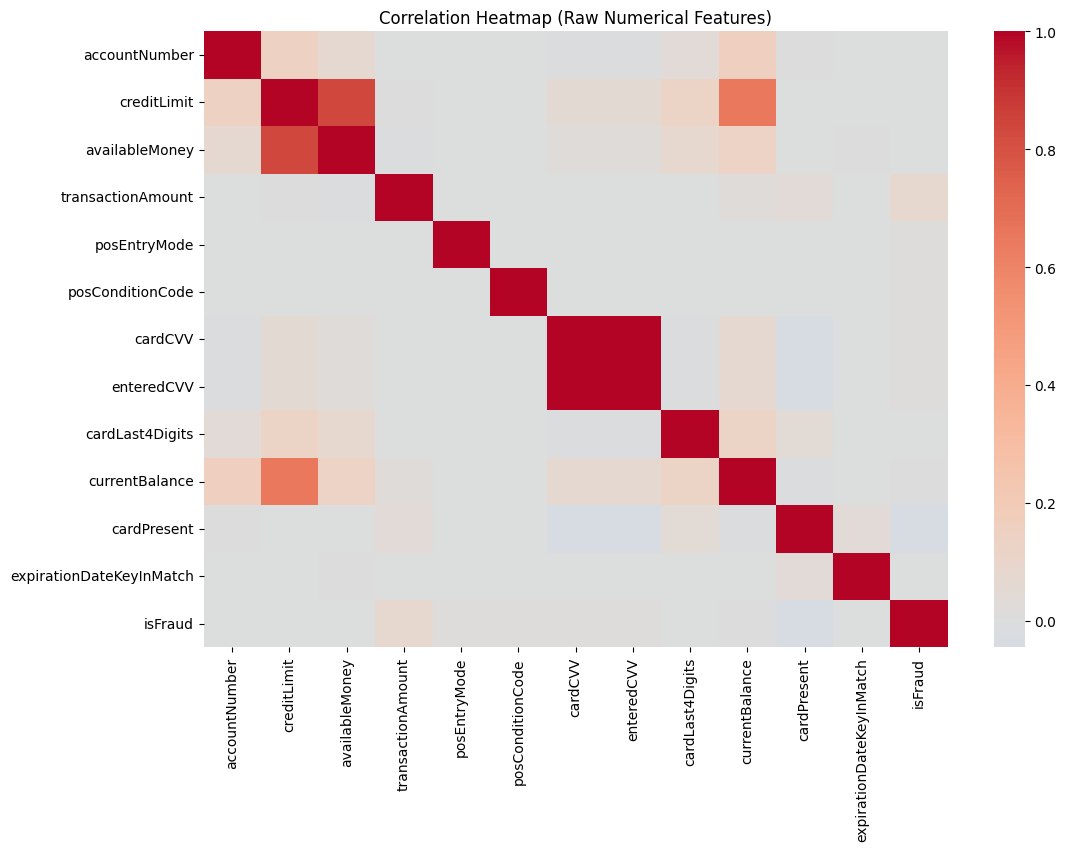

isFraud                     1.000000
transactionAmount           0.075651
enteredCVV                  0.008655
cardCVV                     0.008652
posConditionCode            0.008155
posEntryMode                0.007886
currentBalance              0.007715
creditLimit                 0.003108
cardLast4Digits             0.000886
expirationDateKeyInMatch   -0.000972
Name: isFraud, dtype: float64

In [ ]:
# Filter numeric columns only
num_df = df.select_dtypes(include=["int64", "float64"])

# Compute correlations
corr = num_df.corr()

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Raw Numerical Features)")
plt.show()

# Optional: zoom in on `isFraud`
corr["isFraud"].sort_values(ascending=False).head(10)
